# Retrieving the Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
pd.core.common.is_list_like = pd.api.types.is_list_like
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split
from scipy import stats
%matplotlib inline

In [2]:
non_daily_input_list = ['STLFSI', 'TB3MS', 'WM2NS', 'WM1NS', 'USROE', 'UNRATE', 'TOTLL', 'TOTCI',
                             'TOTBKCR','TERMCBAUTO48NS','RECPROUSM156N','PSAVERT','PCE','PAYNSA','INDPRO',
                             'CPIAUCSL','CSUSHPINSA','GDP','Bill_Gross_Issues','Bill_Net','Notes_Gross_Issues',
                             'Notes_Net','Bonds_Gross_Issues','Bonds_Net','TOTAL_Gross_Issues','Total_Net_Cash Raised',
                             '10-year issuance','Investment Grade','High Yield','Total','Economic Policy Uncertainty',
                        'Monetary policy','Fiscal Policy',
                        'Health care','National security','Entitlement programs','Regulation','Financial Regulation',
                        'Trade policy','Sovereign debt']

In [47]:
df_tot = pd.read_csv('Data/dataset_iaqf.csv',index_col=0)

In [48]:
df_tot.index = pd.to_datetime(df_tot.index)

# Data Preprocessing

## Some necessary functions

In [51]:
def create_Xt_Yt(X, y, percentage1=0.7,percentage2=0.15):
    X_train = X.iloc[0:int(X.shape[0] * percentage1),:]
    Y_train = y.iloc[0:int(y.shape[0] * percentage1)]
    X_dev = X.iloc[int(X.shape[0]*percentage1):int(X.shape[0]*(percentage1+percentage2)):,:]
    Y_dev = y.iloc[int(y.shape[0]*percentage1):int(y.shape[0]*(percentage1+percentage2)):]
    X_test = X.iloc[int(X.shape[0]*(percentage1+percentage2)):,:]
    Y_test = y.iloc[int(y.shape[0] * (percentage1+percentage2)):]
    return X_train,X_dev, X_test,Y_train,Y_dev, Y_test

In [52]:
from sklearn.metrics import mean_squared_error
def plot_result(y_pred,y_test,modelName):
    # plot the results
    fig = plt.figure(figsize=(8,4))
    index=y_test.index
    plt.plot(index,y_test,'.r-',label='true')
    plt.plot(index,y_pred,'.b-',label='predict')
    plt.title('Credit Spread Prediction by '+modelName,fontsize = 20)
    plt.legend(loc='upper right')
    plt.xlabel('Date',fontsize = 15)
    plt.ylabel('Credit Spread',fontsize = 15)
    print(modelName+' MSE:'+str(mean_squared_error(y_pred,y_test)))

In [53]:
from scipy.stats import kurtosis,skew,norm
def normFitPlot(dataset):
    dataset = np.squeeze(dataset)
    sns.set_context("paper", rc={"font.size":30,"axes.titlesize":30,"axes.labelsize":20}) 
    sns.distplot(dataset , fit=norm);

    # Get the fitted parameters used by the function
    (mu, sigma) = norm.fit(dataset)
    kur = kurtosis(dataset)
    sk = skew(dataset)
    print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
    print( '\n kurtosis = {:.2f} and skew = {:.2f}\n'.format(kur, sk))

    #Now plot the distribution
    plt.legend(['Distribution $\mu=$ {:.2f} and $\sigma=$ {:.2f} \n kurtosis = {:.2f} and skew = {:.2f}\n'.format(mu, sigma,kur,sk)],
                loc='best',fontsize=10)
    plt.ylabel('Frequency',fontsize=20)
    plt.title('traget distribution',fontsize=30)

    #Get also the QQ-plot
    fig = plt.figure()
    res = stats.probplot(dataset, plot=plt)
    plt.show()

##  Handle Missing Data

In [54]:
non_daily_column = non_daily_input_list
daily_column = df_tot.columns.difference(non_daily_column)

In [56]:
df_tot_nondaily = df_tot[non_daily_column]
df_tot_daily = df_tot[daily_column]

In [57]:
# Delete data on non-trading date
df_tot_daily = df_tot_daily[~df_tot_daily.SPY_High.isnull()]
df_tot_daily = df_tot_daily[~df_tot_daily.DGS10.isnull()]
df_tot_daily = df_tot_daily[~df_tot_daily.BAMLC0A1CAAAEY.isnull()]

In [58]:
df_tot_daily.isnull().sum()[df_tot_daily.isnull().sum()>0].sort_values(ascending = True).head()

^VIX_ROC    1
SPY_TR      1
DPRIME      1
SPY_ROC     1
^VIX_TR     1
dtype: int64

In [59]:
# Simply use a forward fill for other missing data
for i in df_tot_daily:
    df_tot_daily[i] = df_tot_daily[i].fillna(method = 'ffill')

In [60]:
df_tot = df_tot_daily.join(df_tot_nondaily,how = 'outer')

# Data Transformation

In [62]:
feature_col = df_tot.columns.difference(['AAA10Y'])

In [63]:
# Transform our features which are skewed
skewed_feats = df_tot[feature_col].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewDF = pd.DataFrame({'Skew' :skewed_feats})
skewDF.head()

,Skew
^VIX_bl,65.095892
meltdown,14.353858
investment-grade,8.330854
bond broker,7.442682
sell-off,6.761579


In [64]:
skewness = skewDF
skewness = skewness.dropna()
print("There are {} skewed features to Box Cox transform".format(skewness.shape[0]))
skewed_features = skewness.index
lam = 0
df_tot_log = df_tot.copy()
for feat in skewed_features:
    df_tot_log[feat] = np.log(np.abs(df_tot[feat])+1)*np.sign(df_tot[feat])
print("Transform Finished!")

There are 160 skewed features to Box Cox transform
Transform Finished!


In [65]:
skewed_feats = df_tot_log.apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
skewDF = pd.DataFrame({'Skew' :skewed_feats})
skewDF.head()

,Skew
investment-grade,7.104952
^VIX_bl,6.629973
bond broker,5.482865
sell-off,3.747732
TEDRATE,2.253001


## Stationarity check

In [67]:
from statsmodels.tsa.stattools import adfuller
pvalue_dic_daily = {}
stationary_daily = []
non_stationary_daily = []
for i in daily_column.difference(['AAA10Y']):
    cur = df_tot_log[i].dropna()
    p = adfuller(cur)[1]
    pvalue_dic_daily[i] = p
    if p > 0.05:
        non_stationary_daily.append(i)
    else:
        stationary_daily.append(i)

In [68]:
d_daily = {}
stationary_daily = stationary_daily+['AAA10Y']
df_tot_station = df_tot_log[stationary_daily]
for i in non_stationary_daily:
    cur = df_tot_log[i].dropna()
    p = adfuller(cur)[1]
    j = 0
    while p >= 0.05:
        cur = cur.diff(1).fillna(0)
        p = adfuller(cur)[1]
        j = j+1
    df_tot_station = df_tot_station.join(cur,how='outer')
    d_daily[i] = j

In [69]:
# check how many time we differenciate our daily features
d_daily

{'BAMLC0A1CAAAEY': 1,
 'BAMLH0A0HYM2': 1,
 'DAAA': 1,
 'DCOILWTICO': 1,
 'DEXUSEU': 1,
 'DFF': 1,
 'DGS1': 1,
 'DGS10': 1,
 'DGS2': 1,
 'DGS3': 1,
 'DGS3MO': 1,
 'DGS5': 1,
 'DGS6MO': 1,
 'DPRIME': 1,
 'DTWEXB': 1,
 'DTWEXM': 1,
 'Federal Reserve': 1,
 'GDPC1': 1,
 'GOLDAMGBD228NLBM': 1,
 'Investment': 1,
 'Momentum': 1,
 'SPY_Adj Close': 1,
 'SPY_Close': 1,
 'SPY_High': 1,
 'SPY_Low': 1,
 'SPY_MA10': 1,
 'SPY_MA20': 1,
 'SPY_MA5': 1,
 'SPY_NormalizedPrice': 1,
 'SPY_Open': 1,
 'SPY_TR': 1,
 'SPY_Volume': 1,
 'T10Y2Y': 1,
 'T10YFF': 1,
 'USD1MTD156N': 1,
 'USD3MTD156N': 1,
 'Y10Y5': 1,
 'Y3Y2': 1,
 'Y5Y3': 1,
 'bidder': 1,
 'bond broker': 1,
 'buy bond': 1,
 'corporate bond': 1,
 'crash': 1,
 'credit cycle': 1,
 'credit rating': 1,
 'credit spread': 1,
 'debt fund': 1,
 'default': 1,
 'downgrade': 1,
 'funding cost': 1,
 'interest expense': 1,
 'interest penalty': 1,
 'investment-grade': 1,
 'loan': 1,
 'refinance': 1,
 'rf': 1,
 'sell-off': 1,
 'stock': 1,
 'stock market': 1,
 'unempl

In [70]:
pvalue_dic_nd = {}
stationary_nd = []
non_stationary_nd = []
for i in non_daily_column:
    try:
        cur = df_tot_log[i].dropna()
        p = adfuller(cur)[1]
    except:
        print(adfuller(cur))
    pvalue_dic_nd[i] = p
    if p > 0.05:
        non_stationary_nd.append(i)
    else:
        stationary_nd.append(i)

In [71]:
d_nd = {}
for i in non_stationary_nd:
    cur = df_tot_log[i].dropna()
    p = adfuller(cur)[1]
    j = 0
    while p >= 0.05:
        cur = cur.diff(1).fillna(0)
        p = adfuller(cur)[1]
        j = j+1
    df_tot_station = df_tot_station.join(cur,how='outer')
    d_nd[i] = j
df_tot_station = df_tot_station.join(df_tot_log[stationary_nd],how='outer')

In [72]:
d_nd

{'STLFSI': 1,
 'TB3MS': 2,
 'WM2NS': 1,
 'WM1NS': 1,
 'USROE': 1,
 'UNRATE': 2,
 'TOTLL': 1,
 'TOTCI': 1,
 'TOTBKCR': 1,
 'TERMCBAUTO48NS': 2,
 'RECPROUSM156N': 1,
 'PSAVERT': 1,
 'PCE': 1,
 'PAYNSA': 1,
 'INDPRO': 1,
 'CPIAUCSL': 1,
 'CSUSHPINSA': 2,
 'GDP': 1,
 'Bill_Gross_Issues': 1,
 'Notes_Gross_Issues': 1,
 'Notes_Net': 1,
 'Bonds_Gross_Issues': 1,
 'Bonds_Net': 1,
 'TOTAL_Gross_Issues': 1,
 'Total_Net_Cash Raised': 1,
 '10-year issuance': 1,
 'Investment Grade': 1,
 'High Yield': 1,
 'Total': 1,
 'Economic Policy Uncertainty': 1,
 'Health care': 1,
 'Entitlement programs': 1,
 'Regulation': 1,
 'Financial Regulation': 1,
 'Trade policy': 1}

 Most features became stationary after one or two differenciation

In [73]:
df_tot_station = df_tot_station[~df_tot_station.SPY_High.isnull()]
df_tot_station = df_tot_station[~df_tot_station.DGS10.isnull()]
df_tot_station = df_tot_station[~df_tot_station.BAMLC0A1CAAAEY.isnull()]

In [74]:
for i in df_tot_station.columns:
    df_tot_station[i] = df_tot_station[i].fillna(method='ffill')
df_tot_station.dropna(inplace=True)

## Target and input seperation

In [75]:
y = df_tot_station['AAA10Y'].shift(-1)
X = df_tot_station.drop(['AAA10Y'],axis = 1)

In [77]:
X['y_lag1'] = df_tot_station['AAA10Y']
X = X[:-1]
y = y[:-1]
y.name = 'Credit Spread'

## Hidden Markov Model to get market regimes

In [78]:
from hmmlearn.hmm import GaussianHMM
remodel1 = GaussianHMM(n_components=3, covariance_type="full", n_iter=1000,algorithm='map')
remodel1.fit(np.array(y).reshape(-1,1))
Z2 = remodel1.predict(np.array(y).reshape(-1,1))

In [81]:
X['market regime_cs'] = pd.DataFrame(Z2,index=X.index).astype('category')

In [82]:
X_train,X_dev,X_test,y_train,y_dev,y_test = create_Xt_Yt(X,y,0.7,0.15)


 mu = 1.67 and sigma = 0.11


 kurtosis = 0.11 and skew = -0.76



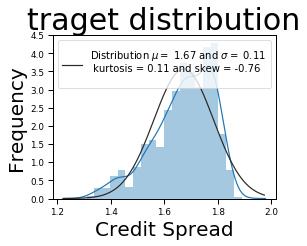

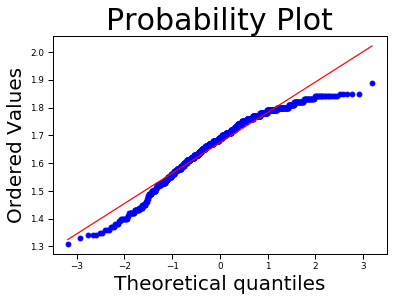


 mu = 0.86 and sigma = 0.14


 kurtosis = 0.64 and skew = 0.99



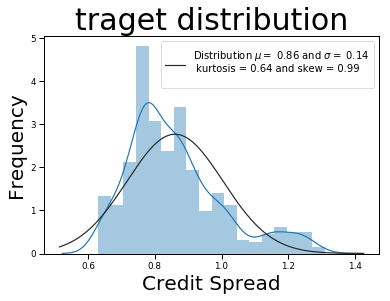

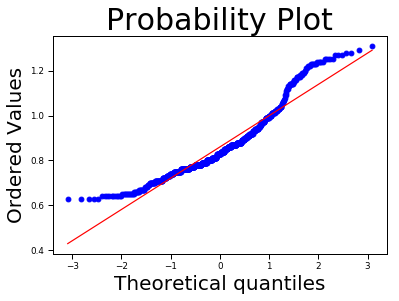


 mu = 2.08 and sigma = 0.25


 kurtosis = 0.83 and skew = 1.37



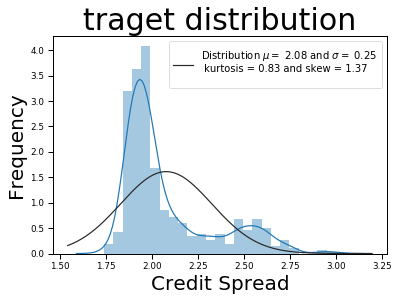

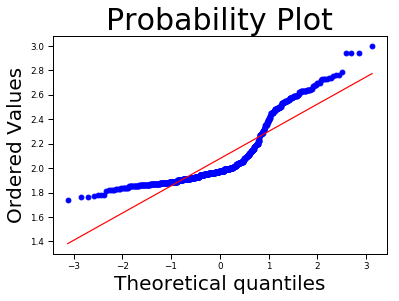

In [83]:
# take a look at the dataset
plt.figure(figsize = (4,3))
for i in range(remodel1.n_components):
    pos = (X_train['market regime_cs'] == i)
    normFitPlot(y_train[pos])

# Data Exploration 

Text(0, 0.5, 'credit spread')

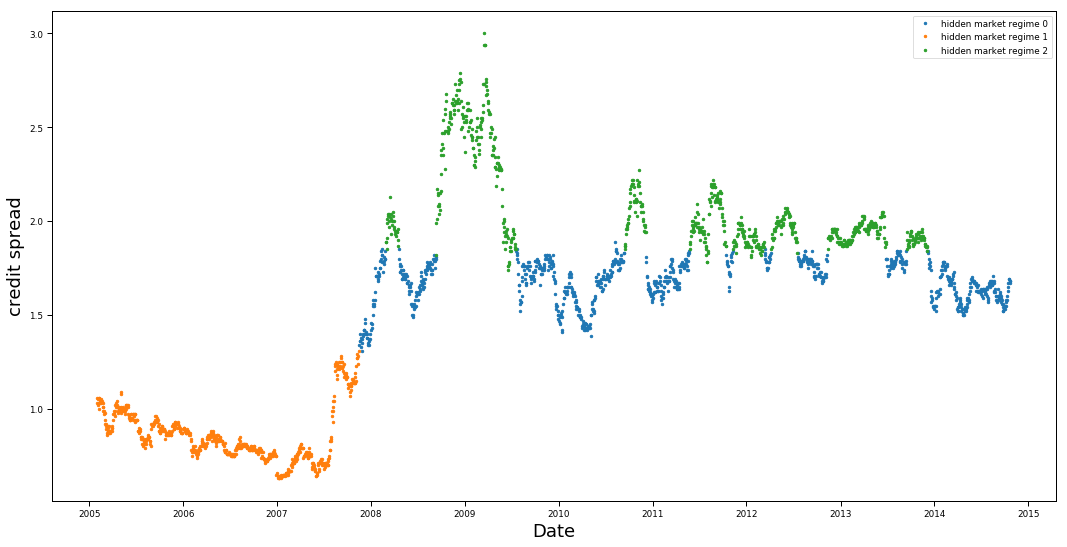

In [85]:
# take a look at the dataset
plt.figure(figsize = (18,9))
for i in range(remodel1.n_components):
    pos = (X_train['market regime_cs'] == i)
    plt.plot(X_train.index[pos],y_train[pos],'.',label='hidden market regime {}'.format(i),lw=1)
plt.legend(loc='best')
plt.xlabel('Date',fontsize=18)
plt.ylabel('credit spread',fontsize=18)


 mu = 1.57 and sigma = 0.51


 kurtosis = -0.68 and skew = -0.25



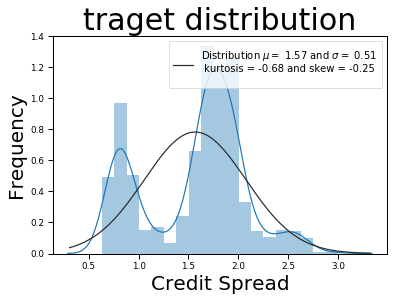

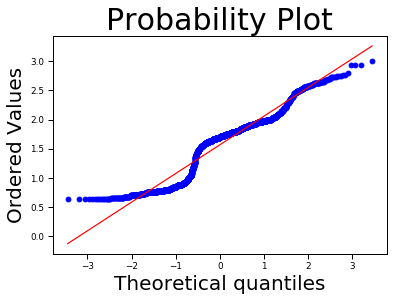

In [86]:
# take a look at the distribution of y_train
normFitPlot(y_train)

In [79]:
# use the model to generate 50000 sample then compare the distribution with the credit spread 
a,_ = remodel1.sample(50000)


 mu = 1.56 and sigma = 0.45


 kurtosis = -0.59 and skew = -0.32



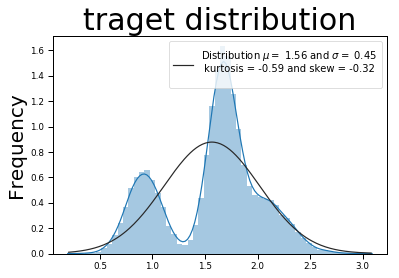

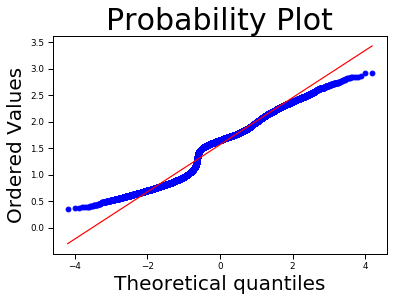

In [80]:
normFitPlot(a)

The generated sample has similar distribution with the credit spread, so we think this HMM model works

Also notice y_train is right-skewed and has fat tail


 mu = 0.92 and sigma = 0.21


 kurtosis = -0.81 and skew = -0.57



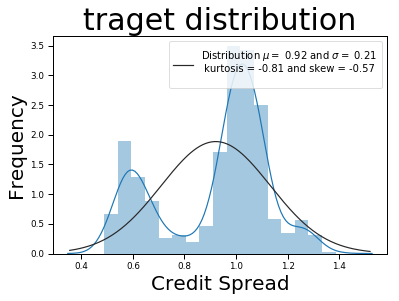

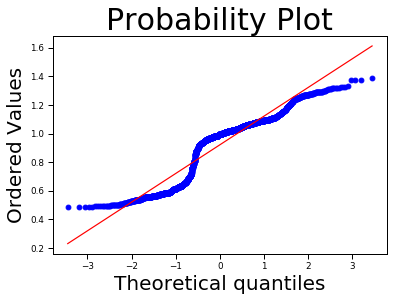

In [88]:
# log-transform for the y_train
y_train_log = np.log(y_train+1)
y_train_sqrt = np.sqrt(y_train+1)
normFitPlot(y_train_log)

In [89]:
n_col = X_train.columns.difference(['market regime_cs'])

In [95]:
from sklearn.preprocessing import MinMaxScaler
x_scaler=MinMaxScaler()
X_train[n_col]=pd.DataFrame(x_scaler.fit_transform(X_train[n_col]),columns = n_col,index=X_train.index)
X_dev[n_col]=pd.DataFrame(x_scaler.transform(X_dev[n_col]),columns = n_col,index=X_dev.index)
X_test[n_col]=pd.DataFrame(x_scaler.transform(X_test[n_col]),columns = n_col,index=X_test.index)

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pa

In [97]:
# Use PCA to VIX price features
vix_features = ['^VIX_Adj Close','^VIX_Close', '^VIX_High', '^VIX_Low','^VIX_MA5', '^VIX_Open','^VIX_NormalizedPrice','^VIX_MA10','^VIX_MA20']
from sklearn.decomposition import PCA
pca = PCA(n_components=0.99,svd_solver = 'full')
vix_new_train = pca.fit_transform(X_train[vix_features])
vix_new_dev = pca.transform(X_dev[vix_features])
vix_new_test = pca.transform(X_test[vix_features])
vix_new_train = pd.DataFrame(vix_new_train,columns=['vix_new1','vix_new2'],index = X_train.index)
vix_new_dev = pd.DataFrame(vix_new_dev,columns=['vix_new1','vix_new2'],index = X_dev.index)
vix_new_test = pd.DataFrame(vix_new_test,columns=['vix_new1','vix_new2'],index = X_test.index)
X_train.drop(vix_features,axis=1,inplace=True)
X_dev.drop(vix_features,axis=1,inplace=True)
X_test.drop(vix_features,axis=1,inplace=True)
X_train = X_train.join(vix_new_train,how='left')
X_dev = X_dev.join(vix_new_dev,how='left')
X_test = X_test.join(vix_new_test,how='left')

/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3930: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [98]:
#find feature importance using Random Forest
import plotly.offline as py
py.init_notebook_mode(connected=True)
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.offline as offline
init_notebook_mode(connected=True)
from sklearn.ensemble import RandomForestRegressor
def find_importance(df_X,df_y,importance):
    from sklearn.ensemble import RandomForestRegressor
    import plotly.graph_objs as go
    
    rf = RandomForestRegressor(n_estimators=1000, max_depth=5, min_samples_leaf=4, max_features=0.1)
    rf.fit(df_X, df_y)
    features =df_X.columns.values

    #plot feature importance 
    x, y = (list(x) for x in zip(*sorted(zip(rf.feature_importances_, features), reverse = False)))
    trace2 = go.Bar(
        x=x,
        y=y,
        marker=dict(
            color=x,
            colorscale = 'Viridis',
            reversescale = True
        ),
        name='Random Forest Feature importance',
        orientation='h',
    )

    layout = dict(
        title='Barplot of Feature importances',
         width = 900, height = 1000,
        yaxis=dict(
            showgrid=False,
            showline=False,
            showticklabels=True,
    #         domain=[0, 0.85],
        ),
        margin=dict(
        l=300,
    ),
    )

    fig1 = go.Figure(data=[trace2])
    fig1['layout'].update(layout)
    py.iplot(fig1, filename='plots')
    
    for i in range(len(x)):
        if x[i]<importance:
            df_X=df_X.drop(y[i],axis=1)
    
    return df_X

In [99]:
X_trainnew=find_importance(X_train,y_train_log,0.005)
X_devnew = X_dev[X_trainnew.columns]
X_testnew=X_test[X_trainnew.columns]

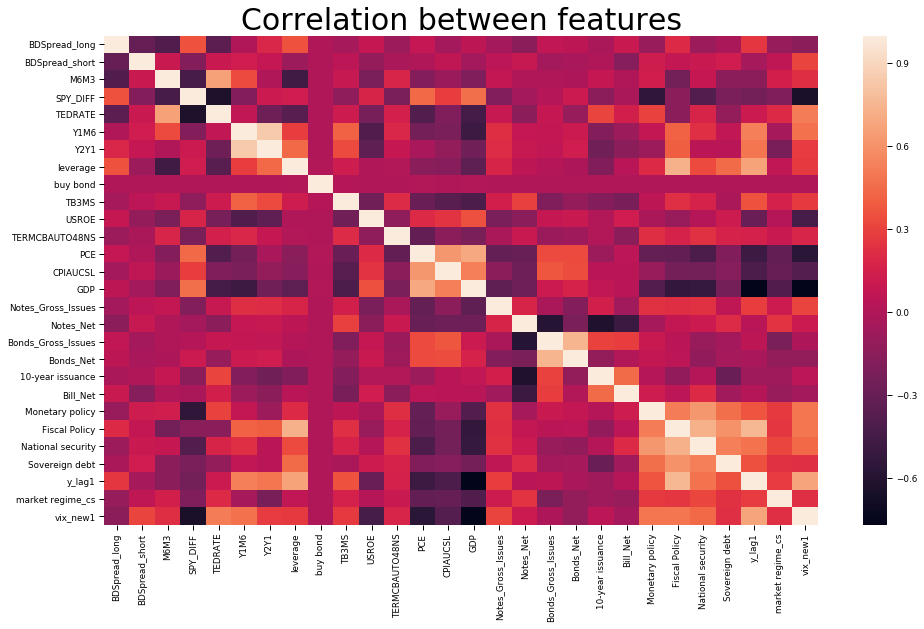

In [100]:
corr = X_trainnew.corr()
f, ax = plt.subplots(figsize=(16, 9))
plt.title("Correlation between features",fontsize = 30)
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)
plt.savefig('corr.png')

# Models

In [103]:
from sklearn.linear_model import Lasso,LinearRegression,Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [104]:
lr = LinearRegression()
ridge = Ridge(random_state=1,alpha =0.0005)
lasso = Lasso(random_state=1,alpha =0.0005)
rfr = RandomForestRegressor(n_estimators=700,max_features='auto',oob_score=True)
xgboost = XGBRegressor(learning_rate=0.01, n_estimators=1000,  max_depth=3,min_samples_split=5,min_samples_leaf=5,
                                max_features=7, subsample=0.7, random_state=10)

Linear Regression MSE:0.002075305310968739
Lasso Regression MSE:0.0010446321512027695
Ridge Regression MSE:0.00207484978288109
Random Forest Regression MSE:0.0027413174259689694
XGBRegressor MSE:0.0008314600838372747


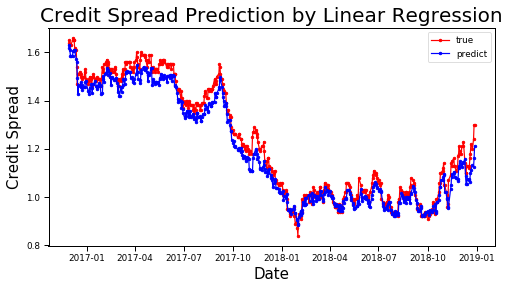

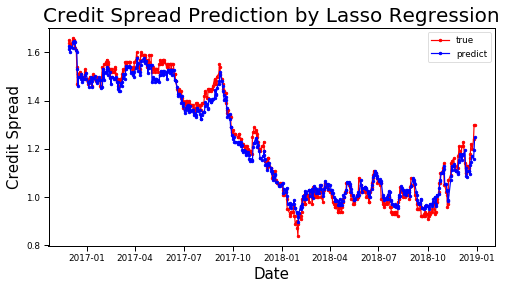

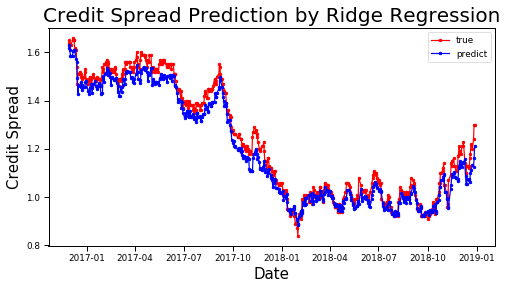

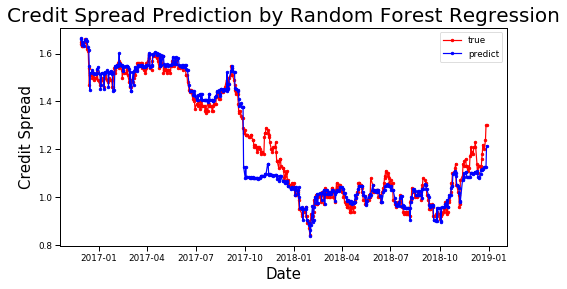

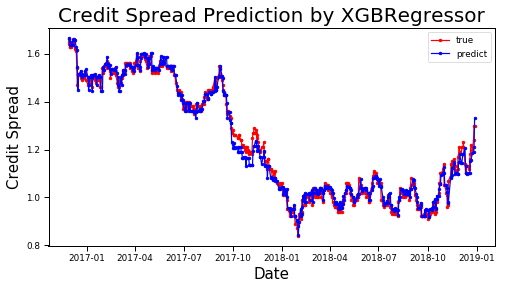

In [105]:
label = ['Linear Regression', 'Lasso Regression','Ridge Regression','Random Forest Regression', 'XGBRegressor']
re_list = [lr,lasso,ridge,rfr, xgboost]

for re, label in zip(re_list, label):
    re.fit(X_trainnew,y_train_log)
    y_pred=re.predict(X_testnew)
    plot_result(np.exp(y_pred)-1,y_test,label)